In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train_14.tfrecord
/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train_11.tfrecord
/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_eval_01.tfrecord
/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train_08.tfrecord
/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train_13.tfrecord
/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train_01.tfrecord
/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_test_00.tfrecord
/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train_10.tfrecord
/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train_09.tfrecord
/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train_07.tfrecord
/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train_12.tfrecord
/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train_04.tfrecord
/kaggle/input/next

In [2]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import numpy as np


from tqdm import tqdm
from typing import Callable, Tuple

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.losses_utils import reduce_weighted_loss

In [3]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [4]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Randomly axis-align crop input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
        num_in_channels: number of channels in input_img.
        num_out_channels: number of channels in output_img.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    combined = tf.concat([input_img, output_img], axis=2)
    combined = tf.image.random_crop(
        combined,
        [sample_size, sample_size, num_in_channels + num_out_channels])
    input_img = combined[:, :, 0:num_in_channels]
    output_img = combined[:, :, -num_out_channels:]
    return input_img, output_img
def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Center crops input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    central_fraction = sample_size / input_img.shape[0]
    input_img = tf.image.central_crop(input_img, central_fraction)
    output_img = tf.image.central_crop(output_img, central_fraction)
    return input_img, output_img

In [5]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
    """Extracts the base key from the provided key.

    Earth Engine exports TFRecords containing each data variable with its
    corresponding variable name. In the case of time sequences, the name of the
    data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
    where 'variable' is the name of the variable, and n the number of elements
    in the time sequence. Extracting the base key ensures that each step of the
    time sequence goes through the same normalization steps.
    The base key obeys the following naming pattern: '([a-zA-Z]+)'
    For instance, for an input key 'variable_1', this function returns 'variable'.
    For an input key 'variable', this function simply returns 'variable'.

    Args:
        key: Input key.

    Returns:
        The corresponding base key.

    Raises:
        ValueError when `key` does not match the expected pattern.
    """
    match = re.match(r'([a-zA-Z]+)', key)
    if match:
        return match.group(1)
    
    raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and rescales inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and rescale.
        key: Key describing the inputs.

    Returns:
        Clipped and rescaled input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, _, _ = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and normalizes inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and normalize.
        key: Key describing the inputs.

    Returns:
        Clipped and normalized input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, mean, std = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    inputs = inputs - mean
    return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
    """Creates a features dictionary for TensorFlow IO.

    Args:
        sample_size: Size of the input tiles (square).
        features: List of feature names.

    Returns:
        A features dictionary for TensorFlow IO.
    """
    sample_shape = [sample_size, sample_size]
    features = set(features)
    columns = [
        tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
        for _ in features
    ]
    return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Reads a serialized example.

    Args:
        example_proto: A TensorFlow example protobuf.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        num_in_channels: Number of input channels.
        clip_and_normalize: True if the data should be clipped and normalized.
        clip_and_rescale: True if the data should be clipped and rescaled.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data should be cropped in the center.

    Returns:
        (input_img, output_img) tuple of inputs and outputs to the ML model.
    """
    if (random_crop and center_crop):
        raise ValueError('Cannot have both random_crop and center_crop be True')
    input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
    feature_names = input_features + output_features
    features_dict = _get_features_dict(data_size, feature_names)
    features = tf.io.parse_single_example(example_proto, features_dict)

    if clip_and_normalize:
        inputs_list = [
            _clip_and_normalize(features.get(key), key) for key in input_features
        ]
    elif clip_and_rescale:
        inputs_list = [
            _clip_and_rescale(features.get(key), key) for key in input_features
        ]
    else:
        inputs_list = [features.get(key) for key in input_features]
  
    inputs_stacked = tf.stack(inputs_list, axis=0)
    input_img = tf.transpose(inputs_stacked, [1, 2, 0])

    outputs_list = [features.get(key) for key in output_features]
    assert outputs_list, 'outputs_list should not be empty'
    outputs_stacked = tf.stack(outputs_list, axis=0)

    outputs_stacked_shape = outputs_stacked.get_shape().as_list()
    assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
    output_img = tf.transpose(outputs_stacked, [1, 2, 0])

    if random_crop:
        input_img, output_img = random_crop_input_and_output_images(
            input_img, output_img, sample_size, num_in_channels, 1)
    if center_crop:
        input_img, output_img = center_crop_input_and_output_images(
            input_img, output_img, sample_size)
    return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
    """Gets the dataset from the file pattern.

    Args:
        file_pattern: Input file pattern.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        batch_size: Batch size.
        num_in_channels: Number of input channels.
        compression_type: Type of compression used for the input files.
        clip_and_normalize: True if the data should be clipped and normalized, False
          otherwise.
        clip_and_rescale: True if the data should be clipped and rescaled, False
          otherwise.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data shoulde be cropped in the center.

    Returns:
        A TensorFlow dataset loaded from the input file pattern, with features
        described in the constants, and with the shapes determined from the input
        parameters to this function.
    """
    if (clip_and_normalize and clip_and_rescale):
        raise ValueError('Cannot have both normalize and rescale.')
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(
        lambda x: _parse_fn(  # pylint: disable=g-long-lambda
            x, data_size, sample_size, num_in_channels, clip_and_normalize,
            clip_and_rescale, random_crop, center_crop),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [6]:
BATCH_SIZE = 32

train_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train*', 
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

validation_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_eval*', 
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

test_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_test*',
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

In [7]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]


In [8]:
def plot_samples_from_dataset(dataset: tf.data.Dataset, n_rows: int):
    """
    Plot 'n_rows' rows of samples from dataset.
    
    Args:
        dataset (Dataset): Dataset from which to plot samples.
        n_rows (int): Number of rows to plot.
    """
    global TITLES
    
    # Get batch
    inputs, labels = None, None
    for elem in dataset:
        inputs, labels = elem
        break
    
    fig = plt.figure(figsize=(15,6.5))

    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    # Number of data variables
    n_features = 12
    for i in range(n_rows):
        for j in range(n_features + 1):
            plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
            if i == 0:
                plt.title(TITLES[j], fontsize=13)
            if j < n_features - 1:
                plt.imshow(inputs[i, :, :, j], cmap='viridis')
            if j == n_features - 1:
                plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
            if j == n_features:
                plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM) 
            plt.axis('off')
    plt.tight_layout()

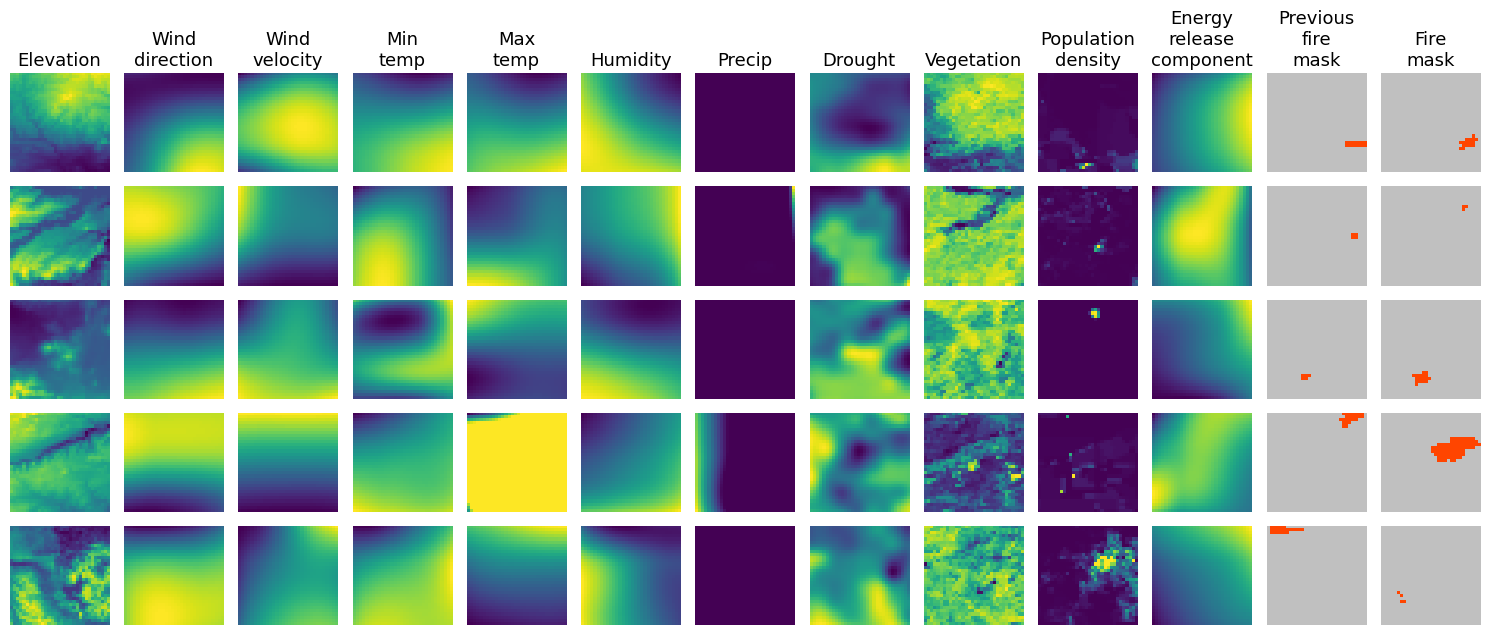

In [9]:
plot_samples_from_dataset(train_dataset, 5)

In [10]:
!pip install git+https://github.com/tensorflow/examples.git

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-1wfoajuz
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-1wfoajuz
  Resolved https://github.com/tensorflow/examples.git to commit 2e95a044383d9a4d2fa978a425180805f459895d
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1731953255.265950347672184340704816478695313217983253940573-py3-none-any.whl size=301600 sha256=7c1b588a6091418d3947381be1e64cfe53c0e984172c64e4f71b18b264ff992d
  Stored in directory: /tmp/pip-ephem-wheel-cache-tr95x_di/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [11]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
from tqdm import tqdm
from typing import Callable, Tuple

# Intersection over Union (IoU) Metric
def IoU_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculates the Intersection over Union (IoU) metric.
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)
    intersection = np.logical_and(real_mask, predicted_mask)
    union = np.logical_or(real_mask, predicted_mask)
    
    if np.sum(union) == 0:
        return 1.0  # Perfect match if both masks are empty
    return np.sum(intersection) / np.sum(union)

# Recall Metric
def recall_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculates the recall (sensitivity) metric.
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)
    true_positives = np.sum(np.logical_and(real_mask, predicted_mask))
    actual_positives = np.sum(real_mask)
    if actual_positives == 0:
        return 1.0
    return true_positives / actual_positives

# Precision Metric
def precision_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculates the precision metric.
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)
    true_positives = np.sum(np.logical_and(real_mask, predicted_mask))
    predicted_positives = np.sum(predicted_mask)
    if predicted_positives == 0:
        return 1.0
    return true_positives / predicted_positives

# F1-Score

def calculate_f1_score(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculates the F1-Score.
    """
    precision = precision_metric(real_mask, predicted_mask)
    recall = recall_metric(real_mask, predicted_mask)
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)



# False Alarm Rate (FAR)
def false_alarm_rate(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculates the False Alarm Rate (FAR).
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)
    false_positives = np.sum(np.logical_and(predicted_mask, np.logical_not(real_mask)))
    predicted_positives = np.sum(predicted_mask)
    if predicted_positives == 0:
        return 0.0
    return false_positives / predicted_positives

# Dice Coefficient
def dice_coef(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Dice coefficient for similarity measurement.
    """
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Weighted Binary Crossentropy
def weighted_bincrossentropy(true: tf.Tensor, pred: tf.Tensor, weight_zero: float = 0.01, weight_one: float = 1.0) -> tf.Tensor:
    """
    Calculates weighted binary crossentropy.
    """
    bin_crossentropy = K.binary_crossentropy(true, pred)
    weights = true * weight_one + (1. - true) * weight_zero
    return K.mean(weights * bin_crossentropy)

# BCE + Dice Loss
def bce_dice_loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Combines Binary Crossentropy and Dice Loss.
    """
    return weighted_bincrossentropy(y_true, y_pred) + (1 - dice_coef(y_true, y_pred))



In [12]:
# Accuracy Metric
# Accuracy Metric
def accuracy_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculates the accuracy metric.
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)  # Ensure no negative values
    real_mask_np = real_mask.numpy()  # Convert to NumPy array for operations
    predicted_mask_np = predicted_mask.numpy()  # Convert to NumPy array for operations
    
    total_pixels = real_mask_np.size  # Use NumPy's size attribute
    correct_predictions = np.sum(real_mask_np == predicted_mask_np)
    return correct_predictions / total_pixels


# Updated Evaluation Pipeline
def evaluate_model(prediction_function: Callable[[tf.Tensor], tf.Tensor], 
                   eval_dataset: tf.data.Dataset) -> Tuple[float, float, float, float, float, float, float]:
    """
    Evaluates the model using various metrics including Accuracy.
    """
    IoU_measures = []
    recall_measures = []
    precision_measures = []
    f1_scores = []
    far_scores = []
    accuracy_measures = []
    losses = []
    
    for inputs, labels in tqdm(eval_dataset):
        predictions = prediction_function(inputs)
        for i in range(inputs.shape[0]):
            IoU_measures.append(IoU_metric(labels[i, :, :, 0], predictions[i, :, :]))
            recall_measures.append(recall_metric(labels[i, :, :, 0], predictions[i, :, :]))
            precision_measures.append(precision_metric(labels[i, :, :, 0], predictions[i, :, :]))
            computed_f1_score = calculate_f1_score(labels[i, :, :, 0], predictions[i, :, :])
            f1_scores.append(computed_f1_score)
            #f1_scores.append(f1_score(labels[i, :, :, 0], predictions[i, :, :]))
            far_scores.append(false_alarm_rate(labels[i, :, :, 0], predictions[i, :, :]))
            accuracy_measures.append(accuracy_metric(labels[i, :, :, 0], predictions[i, :, :]))
        labels_cleared = tf.where(labels < 0, 0, labels)
        losses.append(bce_dice_loss(labels_cleared, tf.expand_dims(tf.cast(predictions, tf.float32), axis=-1)))
    
    return (
        np.mean(IoU_measures),
        np.mean(recall_measures),
        np.mean(precision_measures),
        np.mean(f1_scores),
        np.mean(far_scores),
        np.mean(accuracy_measures),
        np.mean(losses)
    )


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LSTM, Reshape, Dropout, Input, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def upsample(filters, size, kernel_regularizer=None):
    """
    Custom upsampling layer with L2 regularization.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            kernel_regularizer=kernel_regularizer,
            use_bias=False
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ])
    return result

def build_CNN_RNN_AE_model() -> Model:
    """
    Create CNN + RNN autoencoder model with regularization to prevent overfitting.
    
    Returns:
        (Model): Keras model.
    """
    # Define the base MobileNetV2 model
    base_model = tf.keras.applications.MobileNetV2(input_shape=[32, 32, 12], include_top=False, weights=None)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 32x32
        'block_3_expand_relu',   # 16x16
        'block_6_expand_relu',   # 8x8
        'block_13_expand_relu',  # 4x4
        'block_16_project',      # 1x1
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
    down_stack.trainable = True

    # Define the upsampling stack with L2 regularization
    up_stack = [
        upsample(512, 3, kernel_regularizer=l2(1e-4)),  # 2x2 -> 4x4
        upsample(256, 3, kernel_regularizer=l2(1e-4)),  # 4x4 -> 8x8
        upsample(128, 3, kernel_regularizer=l2(1e-4)),  # 8x8 -> 16x16
        upsample(64, 3, kernel_regularizer=l2(1e-4)),   # 16x16 -> 32x32
    ]

    # Define model input
    inputs = tf.keras.layers.Input(shape=[32, 32, 12])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]  # Bottleneck output
    skips = reversed(skips[:-1])

    # Add RNN block at the bottleneck
    x = tf.keras.layers.Reshape((1, 320))(x)  # Flatten spatial dimensions for RNN
    x = tf.keras.layers.LSTM(512, return_sequences=True, activation='tanh', dropout=0.3)(x)
    x = tf.keras.layers.LSTM(512, activation='tanh', dropout=0.3)(x)
    x = tf.keras.layers.Reshape((1, 1, 512))(x)  # Reshape back to spatial dimensions

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Dropout(0.3)(x)  # Add dropout to the upsampled features
        x = Concatenate()([x, skip])

    # Final layer to restore original spatial resolution
    last = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=2, padding='same'
    )  # 64x64 -> 128x128

    x = last(x)
    outputs = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Create the segmentation model
segmentation_model = build_CNN_RNN_AE_model()
segmentation_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/applications/mobilenet_v2.py:208: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 12 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ [(None, 16, 16,   │  1,844,576 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 8, 8, │            │                   │
│                     │ 144), (None, 4,   │            │                   │
│                     │ 4, 192), (None,   │            │                   │
│                     │ 2, 2, 576),       │            │                   │
│                     │ (None, 1, 1,      │            │                   │
│                     │ 320)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 320)    │          0 │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 512)    │  1,705,984 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 512)       │  2,099,200 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 512) │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 2, 2, 512) │  2,361,344 │ reshape_1[0][0]   │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2, 2, 512) │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ dropout[0][0],    │
│ (Concatenate)       │ 1088)             │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 4, 4, 256) │  2,507,776 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 4, 4, 256) │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4, 448) │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 8, 8, 128) │    516,608 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 8, 128) │          0 │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8, 272) │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │    156,928 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ sequential_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,193,859 (42.70 MB)

 Trainable params: 11,161,027 (42.58 MB)

 Non-trainable params: 32,832 (128.25 KB)

In [14]:
def train_model(model: Model, train_dataset: tf.data.Dataset, epochs:int=10) -> Tuple[List[float], List[float]]:
    """
    Trains a model using train dataset. (Save weights of model with best IoU)
    
    Args:
        model (Model): Model to train.
        train_dataset (Dataset): Training dataset.
        epochs (int): Number of epochs
    Returns:
        Tuple[List[float], List[float]]: Train losses and Validation losses
    """
    loss_fn = bce_dice_loss
    optimizer = tf.keras.optimizers.Adam()
    batch_losses = []
    val_losses = []
    best_IoU = 0.0
    
    for epoch in range(epochs):
        losses = []
        print(f'Epoch {epoch+1}/{epochs}')
        # Iterate through the dataset
        progress = tqdm(train_dataset)
        for images, masks in progress:
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = model(images, training=True)
                label = tf.where(masks < 0, 0, masks)
                # Compute the loss
                loss = loss_fn(label, predictions)
                losses.append(loss.numpy())
                progress.set_postfix({'batch_loss': loss.numpy()})
            # Compute gradients
            gradients = tape.gradient(loss, model.trainable_variables)
            # Update the model's weights
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # Evaluate model
        print("Evaluation...")
        IoU, recall, precision, f1_score, far, accuracy, val_loss = evaluate_model(
    lambda x: tf.where(model.predict(x) > 0.5, 1, 0)[:, :, :, 0], validation_dataset
)

        print("Validation set metrics:")
        print(f"Mean IoU: {IoU}\nAccuracy : {accuracy}\nMean precision: {precision}\nMean recall: {recall}\nF1 score:{f1_score}\nFAR :{far}\nValidation loss: {val_loss}\n")
        # Save best model
        if IoU > best_IoU:
            best_IoU = IoU
            model.save_weights("best.weights.h5")
        
        # Print the loss for monitoring
        print(f'Epoch: {epoch}, Train loss: {np.mean(losses)}')
        batch_losses.append(np.mean(losses))
        val_losses.append(val_loss)
    
    print(f"Best model IoU: {best_IoU}")
    return batch_losses, val_losses

# Set reproducability
tf.random.set_seed(1337)

segmentation_model = build_CNN_RNN_AE_model()
train_losses, val_losses = train_model(segmentation_model, train_dataset, epochs=5)


Epoch 1/5


469it [09:30,  1.22s/it, batch_loss=0.867]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1it [00:03,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


2it [00:03,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


3it [00:03,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


4it [00:03,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


5it [00:04,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


6it [00:04,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


7it [00:04,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


8it [00:05,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


9it [00:05,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


10it [00:05,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


11it [00:06,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


12it [00:06,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


13it [00:06,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


14it [00:06,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


15it [00:07,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


16it [00:07,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


17it [00:07,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


18it [00:08,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


19it [00:08,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


20it [00:08,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


21it [00:08,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


22it [00:09,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


23it [00:09,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


24it [00:09,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


25it [00:10,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


26it [00:10,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


27it [00:10,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


28it [00:11,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


29it [00:11,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


30it [00:11,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


31it [00:11,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


32it [00:12,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


33it [00:12,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


34it [00:12,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


35it [00:13,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


36it [00:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


37it [00:13,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


38it [00:13,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


39it [00:14,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


40it [00:14,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


41it [00:15,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


42it [00:15,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


43it [00:15,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


44it [00:15,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


45it [00:16,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


46it [00:16,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


47it [00:16,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


48it [00:17,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


49it [00:17,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


50it [00:17,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


51it [00:17,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


52it [00:18,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


53it [00:18,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


54it [00:18,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


55it [00:19,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


56it [00:19,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


57it [00:19,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


58it [00:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


59it [00:22,  2.64it/s]

Validation set metrics:
Mean IoU: 0.14118273841236015
Accuracy : 0.9713009248468301
Mean precision: 1.0
Mean recall: 0.14118273841236015
F1 score:0.14118273841236015
FAR :0.0
Validation loss: 1.4460748434066772



Epoch: 0, Train loss: 0.7690434455871582
Epoch 2/5


469it [09:22,  1.20s/it, batch_loss=0.731]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1it [00:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


2it [00:00,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


3it [00:00,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


4it [00:01,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


5it [00:01,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


6it [00:01,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


7it [00:02,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


8it [00:02,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


9it [00:02,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


10it [00:03,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


11it [00:03,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


12it [00:03,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


13it [00:03,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


14it [00:04,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


15it [00:04,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


16it [00:04,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


17it [00:05,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


18it [00:05,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


19it [00:05,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


20it [00:06,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


21it [00:06,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


22it [00:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


23it [00:06,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


24it [00:07,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


25it [00:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


26it [00:07,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


27it [00:08,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


28it [00:08,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


29it [00:08,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


30it [00:09,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


31it [00:09,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


32it [00:09,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


33it [00:09,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


34it [00:10,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


35it [00:10,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


36it [00:10,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


37it [00:11,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


38it [00:11,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


39it [00:11,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


40it [00:11,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


41it [00:12,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


42it [00:12,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


43it [00:12,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


44it [00:13,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


45it [00:13,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


46it [00:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


47it [00:13,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


48it [00:14,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


49it [00:14,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


50it [00:14,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


51it [00:15,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


52it [00:15,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


53it [00:15,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


54it [00:16,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


55it [00:16,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


56it [00:16,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


57it [00:16,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


58it [00:17,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


59it [00:17,  3.37it/s]

Validation set metrics:
Mean IoU: 0.14171550346297282
Accuracy : 0.9706765908031433
Mean precision: 1.0
Mean recall: 0.14171550346297282
F1 score:0.14171550346297282
FAR :0.0
Validation loss: 1.4551724195480347



Epoch: 1, Train loss: 0.7224114537239075
Epoch 3/5


469it [09:21,  1.20s/it, batch_loss=0.836]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1it [00:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2it [00:00,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


3it [00:00,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


4it [00:01,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


5it [00:01,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


6it [00:01,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


7it [00:02,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


8it [00:02,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


9it [00:02,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


10it [00:02,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


11it [00:03,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


12it [00:03,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


13it [00:03,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


14it [00:04,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


15it [00:04,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


16it [00:04,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


17it [00:05,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


18it [00:05,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


19it [00:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


20it [00:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


21it [00:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


22it [00:06,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


23it [00:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


24it [00:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


25it [00:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


26it [00:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


27it [00:07,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


28it [00:08,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


29it [00:08,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


30it [00:08,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


31it [00:09,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


32it [00:09,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


33it [00:09,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


34it [00:09,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


35it [00:10,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


36it [00:10,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


37it [00:10,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


38it [00:11,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


39it [00:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


40it [00:11,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


41it [00:11,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


42it [00:12,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


43it [00:12,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


44it [00:12,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


45it [00:13,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


46it [00:13,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


47it [00:13,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


48it [00:14,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


49it [00:14,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


50it [00:14,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


51it [00:14,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


52it [00:15,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


53it [00:15,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


54it [00:15,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


55it [00:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


56it [00:16,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


57it [00:16,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


58it [00:16,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


59it [00:17,  3.44it/s]


Validation set metrics:
Mean IoU: 0.14064997336174748
Accuracy : 0.9712046733484283
Mean precision: 1.0
Mean recall: 0.14064997336174748
F1 score:0.14064997336174748
FAR :0.0
Validation loss: 1.4452605247497559

Epoch: 2, Train loss: 0.7195774912834167
Epoch 4/5


469it [09:19,  1.19s/it, batch_loss=1.31] 


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1it [00:00,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2it [00:00,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


3it [00:00,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


4it [00:01,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


5it [00:01,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


6it [00:01,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


7it [00:02,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


8it [00:02,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


9it [00:02,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


10it [00:03,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


11it [00:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


12it [00:03,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


13it [00:03,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


14it [00:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


15it [00:04,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


16it [00:04,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


17it [00:05,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


18it [00:05,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


19it [00:05,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


20it [00:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


21it [00:06,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


22it [00:06,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


23it [00:06,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


24it [00:07,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


25it [00:07,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


26it [00:07,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


27it [00:07,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


28it [00:08,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


29it [00:08,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


30it [00:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


31it [00:09,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


32it [00:09,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


33it [00:09,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


34it [00:10,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


35it [00:10,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


36it [00:10,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


37it [00:11,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


38it [00:11,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


39it [00:11,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


40it [00:11,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


41it [00:12,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


42it [00:12,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


43it [00:12,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


44it [00:13,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


45it [00:13,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


46it [00:13,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


47it [00:13,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


48it [00:14,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


49it [00:14,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


50it [00:14,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


51it [00:15,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


52it [00:15,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


53it [00:15,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


54it [00:16,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


55it [00:16,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


56it [00:16,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


57it [00:16,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


58it [00:17,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


59it [00:17,  3.39it/s]

Validation set metrics:
Mean IoU: 0.163168762105154
Accuracy : 0.9694045101891315
Mean precision: 0.8451679781785756
Mean recall: 0.17225519121406438
F1 score:0.17848860143302064
FAR :0.15483202182142444
Validation loss: 1.3275353908538818



Epoch: 3, Train loss: 0.7136584520339966
Epoch 5/5


469it [09:18,  1.19s/it, batch_loss=0.907]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1it [00:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2it [00:00,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


3it [00:00,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


4it [00:01,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


5it [00:01,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


6it [00:01,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


7it [00:02,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


8it [00:02,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


9it [00:02,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


10it [00:02,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


11it [00:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


12it [00:03,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


13it [00:03,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


14it [00:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


15it [00:04,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


16it [00:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


17it [00:04,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


18it [00:05,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


19it [00:05,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


20it [00:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


21it [00:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


22it [00:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


23it [00:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


24it [00:06,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


25it [00:07,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


26it [00:07,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


27it [00:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


28it [00:08,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


29it [00:08,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


30it [00:08,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


31it [00:08,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


32it [00:09,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


33it [00:09,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


34it [00:09,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


35it [00:10,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


36it [00:10,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


37it [00:10,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


38it [00:11,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


39it [00:11,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


40it [00:11,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


41it [00:11,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


42it [00:12,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


43it [00:12,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


44it [00:12,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


45it [00:13,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


46it [00:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


47it [00:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


48it [00:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


49it [00:14,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


50it [00:14,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


51it [00:14,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


52it [00:14,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


53it [00:15,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


54it [00:15,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


55it [00:15,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


56it [00:16,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


57it [00:16,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


58it [00:16,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


59it [00:16,  3.48it/s]

Validation set metrics:
Mean IoU: 0.17996039348634926
Accuracy : 0.9681854979688332
Mean precision: 0.8245599732764117
Mean recall: 0.1980048595065498
F1 score:0.20259886836229407
FAR :0.17544002672358816
Validation loss: 1.2974441051483154



Epoch: 4, Train loss: 0.7071672677993774
Best model IoU: 0.17996039348634926


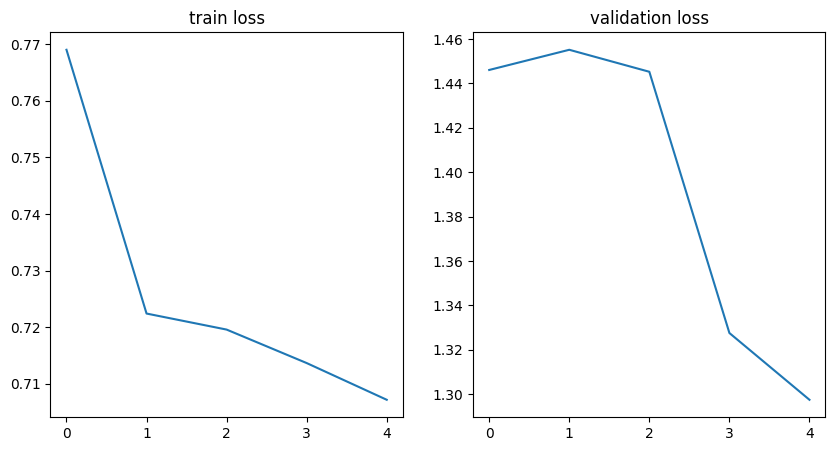

In [15]:
def plot_train_and_val_losses(train_losses, val_losses):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(train_losses)
    axs[0].set_title("train loss")
    
    axs[1].plot(val_losses)
    axs[1].set_title("validation loss")
    
    plt.show()


plot_train_and_val_losses(train_losses, val_losses)

In [16]:
segmentation_model = build_CNN_RNN_AE_model()
segmentation_model.load_weights("/kaggle/working/best.weights.h5")

In [17]:
print("Evaluation...")
print("Test set metrics:")
IoU, recall, precision, f1_score, far, accuracy, val_loss = evaluate_model(
    lambda x: tf.where(segmentation_model.predict(x) > 0.5, 1, 0)[:, :, :, 0], test_dataset
)
print(f"Mean IoU: {IoU}\nAccuracy : {accuracy}\nMean precision: {precision}\nMean recall: {recall}\nF1 score:{f1_score}\nFAR :{far}\nTest loss: {val_loss}\n")

Evaluation...
Test set metrics:


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1it [00:01,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


2it [00:02,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


3it [00:02,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


4it [00:02,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


5it [00:02,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


6it [00:03,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


7it [00:03,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


8it [00:03,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


9it [00:04,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


10it [00:04,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


11it [00:04,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


12it [00:04,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


13it [00:05,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


14it [00:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


15it [00:05,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


16it [00:06,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


17it [00:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


18it [00:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


19it [00:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


20it [00:07,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


21it [00:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


22it [00:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


23it [00:08,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


24it [00:08,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


25it [00:08,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


26it [00:09,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


27it [00:09,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


28it [00:09,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


29it [00:10,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


30it [00:10,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


31it [00:10,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


32it [00:10,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


33it [00:11,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


34it [00:11,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


35it [00:11,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


36it [00:12,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


37it [00:12,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


38it [00:12,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


39it [00:13,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


40it [00:13,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


41it [00:13,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


42it [00:13,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


43it [00:14,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


44it [00:14,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


45it [00:14,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


46it [00:15,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


47it [00:15,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


48it [00:15,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


49it [00:15,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


50it [00:16,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


51it [00:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


52it [00:16,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


53it [00:19,  2.76it/s]

Mean IoU: 0.2132996748703223
Accuracy : 0.9716779529307282
Mean precision: 0.8213121257165871
Mean recall: 0.24017807299495858
F1 score:0.24576641880126535
FAR :0.17868787428341298
Test loss: 1.14061439037323



In [18]:
def show_inference(n_rows: int, features: tf.Tensor, label: tf.Tensor, prediction_function: Callable[[tf.Tensor], tf.Tensor]) -> None:
    """
    Show model inference through images.
    
    Args:
        n_rows (int): Number of rows for subplots.
        features (tf.Tensor): Input features.
        label (tf.Tensor): True labels.
        prediction_function (Callable[[tf.Tensor], tf.Tensor]): Function for model prediction.
    """
    
    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    
    fig = plt.figure(figsize=(15,n_rows*4))
    
    prediction = prediction_function(features)
    for i in range(n_rows):
        plt.subplot(n_rows, 3, i*3 + 1)
        plt.title("Previous day fire")
        plt.imshow(features[i, :, :, -1], cmap=CMAP, norm=NORM)
        plt.axis('off')
        plt.subplot(n_rows, 3, i*3 + 2)
        plt.title("True next day fire")
        plt.imshow(label[i, :, :, 0], cmap=CMAP, norm=NORM)
        plt.axis('off')
        plt.subplot(n_rows, 3, i*3 + 3)
        plt.title("Predicted next day fire")
        plt.imshow(prediction[i, :, :])
        plt.axis('off')    
    plt.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


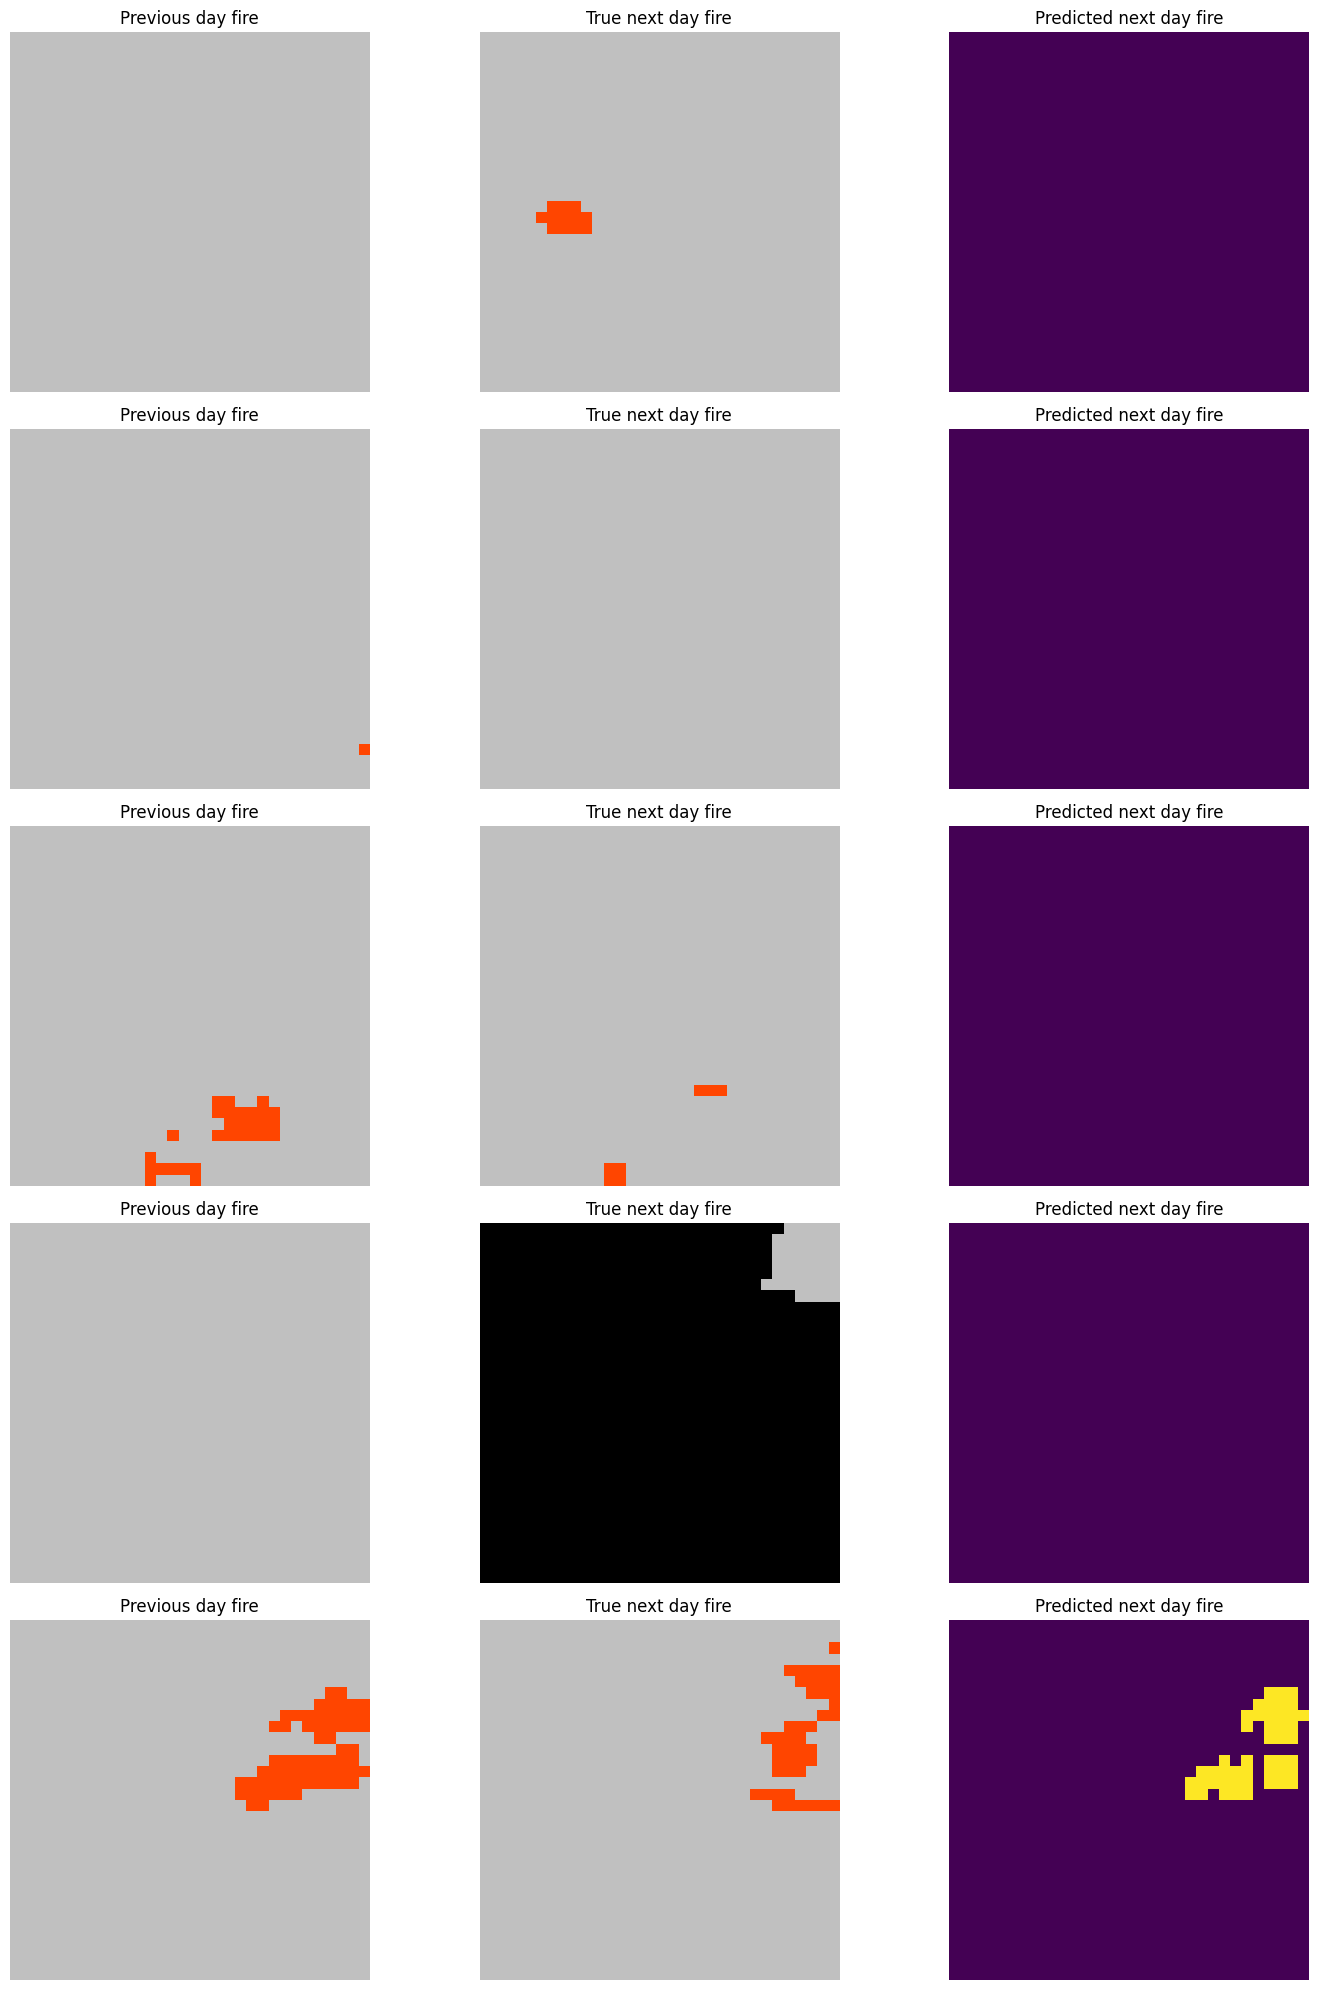

In [20]:
features, labels = next(iter(test_dataset))
show_inference(5, features, labels, lambda x: tf.where(segmentation_model.predict(x) > 0.5, 1, 0)[:,:,:,0])

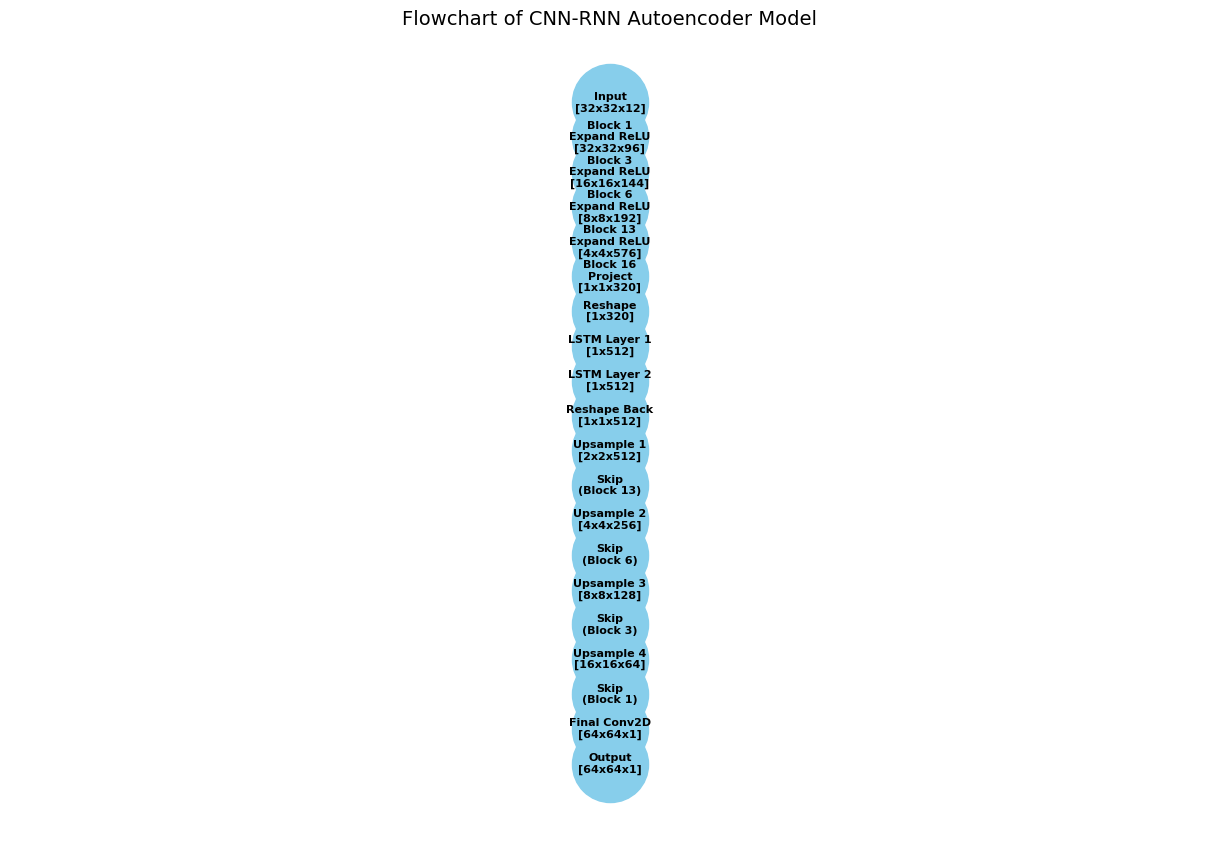

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the graph
G = nx.DiGraph()

# Add nodes with their descriptions
nodes = {
    "input": "Input\n[32x32x12]",
    "down_1": "Block 1\nExpand ReLU\n[32x32x96]",
    "down_2": "Block 3\nExpand ReLU\n[16x16x144]",
    "down_3": "Block 6\nExpand ReLU\n[8x8x192]",
    "down_4": "Block 13\nExpand ReLU\n[4x4x576]",
    "bottleneck": "Block 16\nProject\n[1x1x320]",
    "reshape_rnn": "Reshape\n[1x320]",
    "lstm_1": "LSTM Layer 1\n[1x512]",
    "lstm_2": "LSTM Layer 2\n[1x512]",
    "reshape_back": "Reshape Back\n[1x1x512]",
    "up_1": "Upsample 1\n[2x2x512]",
    "skip_4": "Skip\n(Block 13)",
    "up_2": "Upsample 2\n[4x4x256]",
    "skip_3": "Skip\n(Block 6)",
    "up_3": "Upsample 3\n[8x8x128]",
    "skip_2": "Skip\n(Block 3)",
    "up_4": "Upsample 4\n[16x16x64]",
    "skip_1": "Skip\n(Block 1)",
    "final_conv": "Final Conv2D\n[64x64x1]",
    "output": "Output\n[64x64x1]",
}

# Add edges to represent the flow
edges = [
    ("input", "down_1"),
    ("down_1", "down_2"),
    ("down_2", "down_3"),
    ("down_3", "down_4"),
    ("down_4", "bottleneck"),
    ("bottleneck", "reshape_rnn"),
    ("reshape_rnn", "lstm_1"),
    ("lstm_1", "lstm_2"),
    ("lstm_2", "reshape_back"),
    ("reshape_back", "up_1"),
    ("up_1", "skip_4"),
    ("skip_4", "up_2"),
    ("up_2", "skip_3"),
    ("skip_3", "up_3"),
    ("up_3", "skip_2"),
    ("skip_2", "up_4"),
    ("up_4", "skip_1"),
    ("skip_1", "final_conv"),
    ("final_conv", "output"),
]

# Add nodes and edges to the graph
G.add_nodes_from(nodes.keys())
G.add_edges_from(edges)

# Create node labels for the plot
node_labels = {node: label for node, label in nodes.items()}

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=3000, node_color="skyblue", font_size=8, font_weight="bold", arrowsize=20)

plt.title("Flowchart of CNN-RNN Autoencoder Model", fontsize=14)
plt.show()
